In [57]:
# from google.colab import drive
# drive.mount('/content/drive')

In [58]:
# !pip install category_encoders

In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import category_encoders as ce

from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import train_test_split, KFold, GridSearchCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import make_scorer, f1_score, roc_auc_score, accuracy_score, classification_report, confusion_matrix

In [60]:
df = pd.read_csv("./dataset/train.csv.zip", compression="zip")
train, test = train_test_split(df, train_size=0.7)

In [61]:
# Function to convert to hexavigesimal base
def az_to_int(az, nanVal=None):
    if az==az:  #catch NaN
        hv = 0
        for i in range(len(az)):
            hv += (ord(az[i].lower())-ord('a')+1)*26**(len(az)-1-i)
        return hv
    else:
        if nanVal is not None:
            return nanVal
        else:
            return az

In [62]:
def clean_data(df, cat_cols):
    df.v22 = df.v22.apply(az_to_int)
    df.drop(columns='ID', inplace=True)
    for cat_col in cat_cols:
        df[cat_col].fillna("__MISS__", inplace=True)
    return df

In [63]:
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
train = clean_data(train, cat_cols)
test = clean_data(test, cat_cols)

/Users/aera/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/aera/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4170: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/aera/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:4523: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [64]:
def dplot(data, column, target):
    a = data[column].fillna(data[column].median())
    fig, axes = plt.subplots(figsize=(20, 6), ncols=2, nrows=1)
    sns.kdeplot(data=data, x=column, hue=target, ax=axes[0])
    sns.kdeplot(a, hue=data[target], ax=axes[1])

In [65]:
def catplot(data, column, target):
    x = pd.crosstab(data[column], data[target])
    print(x.apply(lambda x: x/x.sum(), axis='rows'))

In [66]:
y_train = train.pop('target')
y_test = test.pop('target')

In [67]:
cat_encoder = ce.TargetEncoder(cols=cat_cols,  smoothing=100)
train = cat_encoder.fit_transform(train, y=y_train)
test = cat_encoder.transform(test, y=y_test)

/Users/aera/anaconda3/lib/python3.7/site-packages/category_encoders/utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



In [68]:
# imputer = KNNImputer(weights="distance", copy=False)
# imputer.fit_transform(train)

In [69]:
simple_imputer = SimpleImputer(strategy="median", copy=False)
train = simple_imputer.fit_transform(train)
test = simple_imputer.transform(test)

In [70]:
def k_fold_validation(train, y_train, clf, num_folds=5):
    kf = KFold(n_splits=5, random_state=1234)
    clfs = []
    accuracies_train = []
    f1_scores_train  = []
    roc_scores_train = []
    accuracies_test  = []
    f1_scores_test   = []
    roc_scores_test  = []
    for train_index, valid_index in kf.split(train):
        x_train, x_valid = train[train_index], train[valid_index]
        y_train, y_valid = y_train[train_index], y_train[valid_index]
        clf.fit(x_train, y_train)
        # prediction on training data
        yhat_train = clf.predict(x_valid)
        f1_scores_train.append(f1_score(y_train, yhat_train))
        roc_scores_train.append(roc_auc_score(y_train, yhat_train))
        accuracy_train.append(accuracy_score(y_train, yhat_train))
        # prediction on validation data
        ypred_test = clf.predict(x_test)
        f1_scores_test.append(f1_score(y_test, ypred_test))
        roc_scores_test.append(roc_auc_score(y_test, ypred_test))
        accuracy_test.append(accuracy_score(y_test, ypred_test))
        clfs.append(clf)
    # metrics on train data
    accuracy_train = np.mean(np.array(accuracies_train))
    f1_score_train = np.mean(np.array(f1_scores_train))
    roc_score_train = np.mean(np.array(roc_scores_train))
    # metrics on test data
    accuracy_test = np.mean(np.array(accuracies_test))
    f1_score_test = np.mean(np.array(f1_scores_test))
    roc_score_test = np.mean(np.array(roc_scores_test))
    return clfs, {"accuracy_train": accuracy_train, "f1_score_train": f1_score_train, "roc_score_train": roc_score_train, 
                  "accuracy_test": accuracy_test, "f1_score_test": f1_score_test, "roc_score_test": roc_score_test}

In [123]:
def plot_prob_dist(yhat_prob, y):
    plt.figure()
    preds = pd.DataFrame({"yhat_prob_test": yhat_prob[:,1], "y_test": y})
    sns.kdeplot(x=preds['yhat_prob_test'], hue=preds['y_test'])
    plt.show()
    
def print_classification_report(clf, test, y_test):
    yhat_test = clf.predict(test)
    yhat_prob_test = clf.predict_proba(test)
    print("********************************************************")
    print("Accuracy on Test data ", accuracy_score(y_test, yhat_test))
    print("********************************************************")
    print("F1 on Test data ", f1_score(y_test, yhat_test))
    print("********************************************************")
    print("AUC ROC on Test data ", roc_auc_score(y_test, yhat_test))
    print("********************************************************")
    print("Confusion matrix \n", confusion_matrix(y_test, yhat_test))
    print("********************************************************")
    print(classification_report(y_test, yhat_test))
    print("********************************************************")
    plot_prob_dist(yhat_prob_test, y_test)

### Decision tree performance wrt max depth

In [71]:
max_depths = [50, 60, 70, 80, 90, 100, 110, 120, 130]
params = {"max_depth": max_depths}
scoring = {'AUC': make_scorer(roc_auc_score), 'Accuracy': make_scorer(accuracy_score), "F1 Score": make_scorer(f1_score)}
clf = DecisionTreeClassifier(criterion="gini", splitter="best", random_state=1234)
gs = GridSearchCV(clf, cv=5, n_jobs=-2, param_grid=params, scoring=scoring, return_train_score=True, refit="AUC")
gs.fit(train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=1234),
             n_jobs=-2,
             param_grid={'max_depth': [50, 60, 70, 80, 90, 100, 110, 120, 130]},
             refit='AUC', return_train_score=True,
             scoring={'AUC': make_scorer(roc_auc_score),
                      'Accuracy': make_scorer(accuracy_score),
                      'F1 Score': make_scorer(f1_score)})

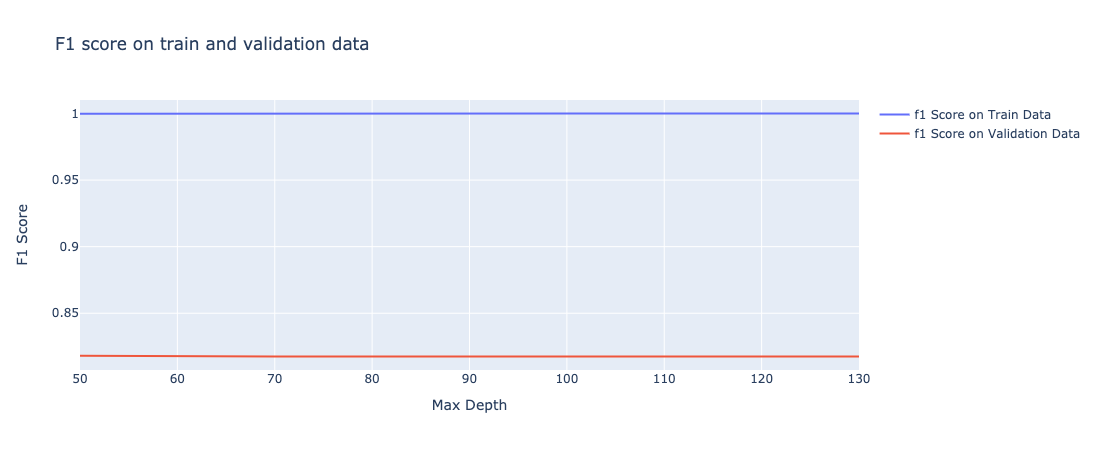

In [72]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=max_depths, y=gs.cv_results_['mean_train_F1 Score'], mode='lines', name='f1 Score on Train Data'))
fig.add_trace(go.Scatter(x=max_depths, y=gs.cv_results_['mean_test_F1 Score'], mode='lines', name='f1 Score on Validation Data'))
fig.update_layout(title='F1 score on train and validation data', xaxis_title='Max Depth', yaxis_title='F1 Score')
fig.show()

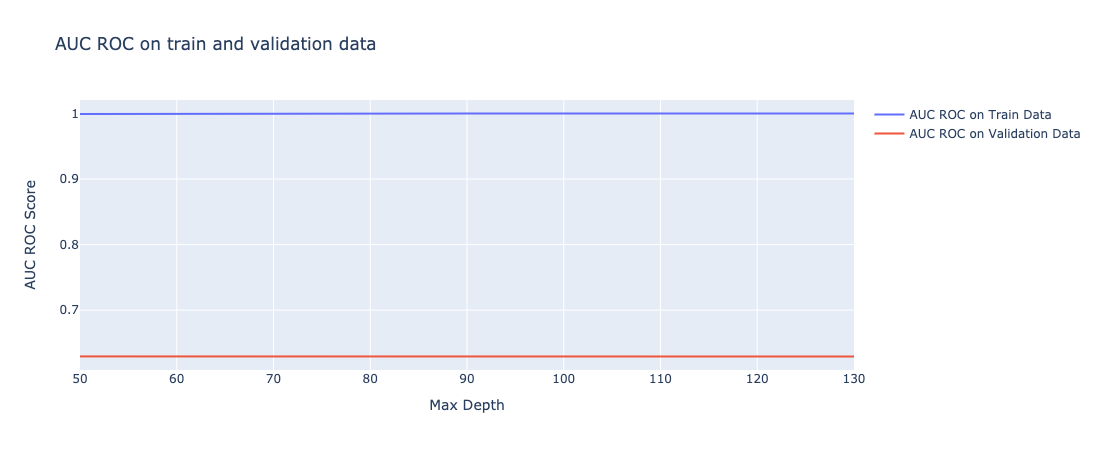

In [73]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=max_depths, y=gs.cv_results_['mean_train_AUC'], mode='lines', name='AUC ROC on Train Data'))
fig.add_trace(go.Scatter(x=max_depths, y=gs.cv_results_['mean_test_AUC'], mode='lines', name='AUC ROC on Validation Data'))
fig.update_layout(title='AUC ROC on train and validation data', xaxis_title='Max Depth', yaxis_title='AUC ROC Score')
fig.show()

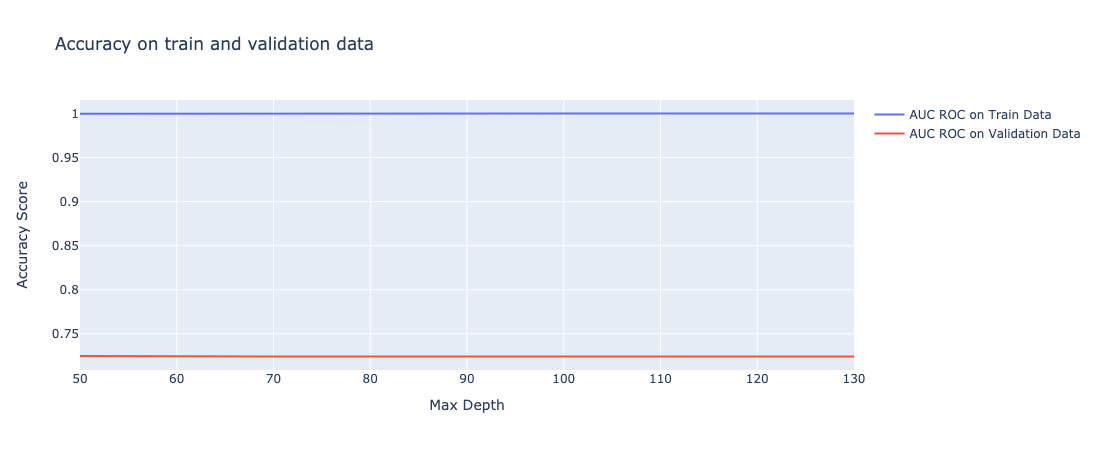

In [74]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=max_depths, y=gs.cv_results_['mean_train_Accuracy'], mode='lines', name='AUC ROC on Train Data'))
fig.add_trace(go.Scatter(x=max_depths, y=gs.cv_results_['mean_test_Accuracy'], mode='lines', name='AUC ROC on Validation Data'))
fig.update_layout(title='Accuracy on train and validation data', xaxis_title='Max Depth', 
                  yaxis_title='Accuracy Score')
fig.show()

********************************************************
Accuracy on Test data  0.7513485144473278
********************************************************
F1 on Test data  0.8478827012949948
********************************************************
AUC ROC on Test data  0.5773598279027239
********************************************************
Confusion matrix 
 [[ 2002  6169]
 [ 2359 23767]]
********************************************************
              precision    recall  f1-score   support

           0       0.46      0.25      0.32      8171
           1       0.79      0.91      0.85     26126

    accuracy                           0.75     34297
   macro avg       0.63      0.58      0.58     34297
weighted avg       0.71      0.75      0.72     34297

********************************************************


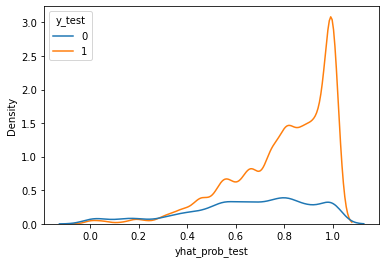

In [124]:
print_classification_report(gs.best_estimator_, test, y_test)

### Decision tree performance wrt pruning alpha

In [75]:
ccp_alphas = [0, 1e-5, 1e-4, 1e-3]
params = {"ccp_alpha": ccp_alphas}
scoring = {'AUC': make_scorer(roc_auc_score), 'Accuracy': make_scorer(accuracy_score), "F1 Score": make_scorer(f1_score)}
clf = DecisionTreeClassifier(criterion="gini", splitter="best", random_state=1234)
gs = GridSearchCV(clf, cv=5, n_jobs=-2, param_grid=params, scoring=scoring, return_train_score=True, refit="AUC")
gs.fit(train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=1234),
             n_jobs=-2, param_grid={'ccp_alpha': [0, 1e-05, 0.0001, 0.001]},
             refit='AUC', return_train_score=True,
             scoring={'AUC': make_scorer(roc_auc_score),
                      'Accuracy': make_scorer(accuracy_score),
                      'F1 Score': make_scorer(f1_score)})

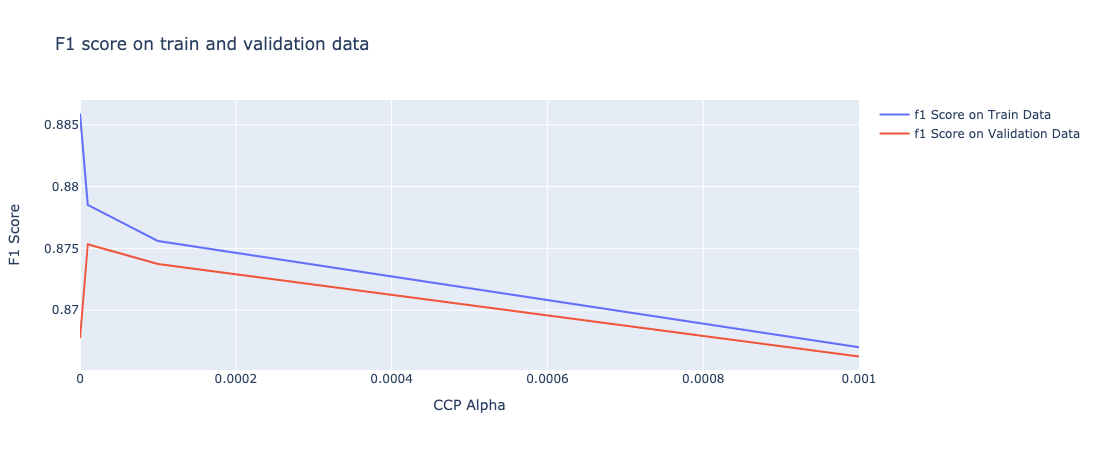

In [84]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=ccp_alphas, y=gs.cv_results_['mean_train_F1 Score'], mode='lines', name='f1 Score on Train Data'))
fig.add_trace(go.Scatter(x=ccp_alphas, y=gs.cv_results_['mean_test_F1 Score'], mode='lines', name='f1 Score on Validation Data'))
fig.update_layout(title='F1 score on train and validation data', xaxis_title='CCP Alpha', yaxis_title='F1 Score')
fig.show()

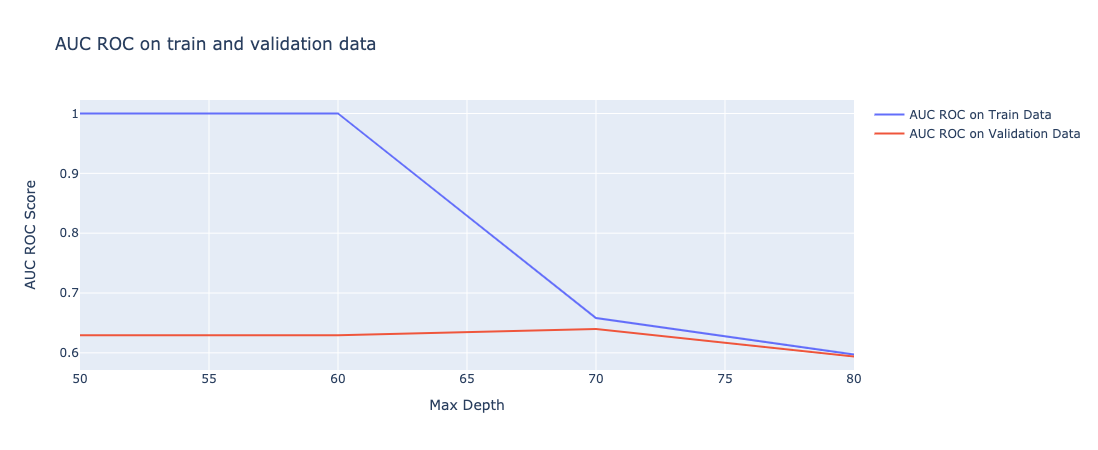

In [77]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=ccp_alphas, y=gs.cv_results_['mean_train_AUC'], mode='lines', name='AUC ROC on Train Data'))
fig.add_trace(go.Scatter(x=ccp_alphas, y=gs.cv_results_['mean_test_AUC'], mode='lines', name='AUC ROC on Validation Data'))
fig.update_layout(title='AUC ROC on train and validation data', xaxis_title='CCP Alpha', yaxis_title='AUC ROC Score')
fig.show()

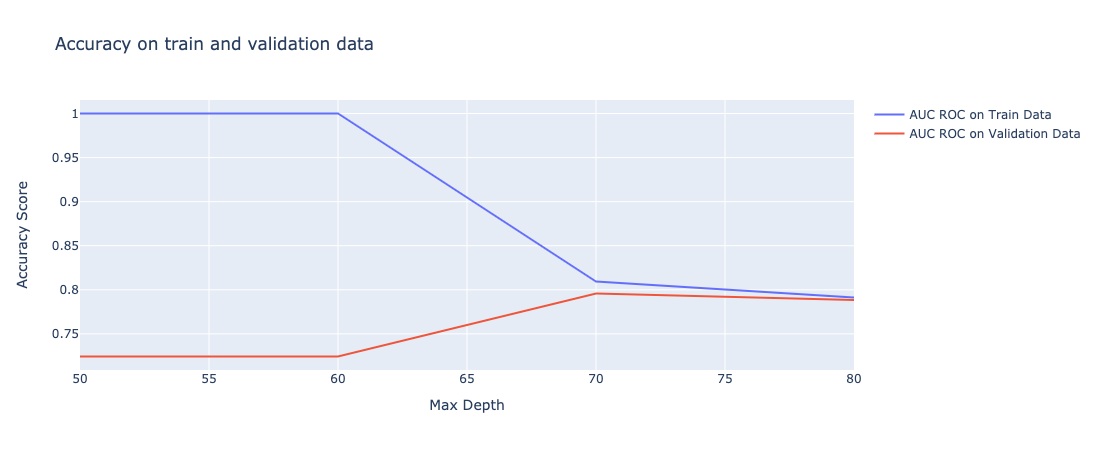

In [78]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=ccp_alphas, y=gs.cv_results_['mean_train_Accuracy'], mode='lines', name='AUC ROC on Train Data'))
fig.add_trace(go.Scatter(x=ccp_alphas, y=gs.cv_results_['mean_test_Accuracy'], mode='lines', name='AUC ROC on Validation Data'))
fig.update_layout(title='Accuracy on train and validation data', xaxis_title='CCP Alpha', 
                  yaxis_title='Accuracy Score')
fig.show()

In [ ]:
print_classification_report(gs.best_estimator_, test, y_test)

## Decision tree performance with min sample leaf

In [93]:
min_samples_leaves = [0.001, 0.005, 0.01, 0.05, 0.1]
params = {"min_samples_leaf": min_samples_leaves}
scoring = {'AUC': make_scorer(roc_auc_score), 'Accuracy': make_scorer(accuracy_score), "F1 Score": make_scorer(f1_score)}
clf = DecisionTreeClassifier(criterion="gini", splitter="best", random_state=1234)
gs = GridSearchCV(clf, cv=5, n_jobs=-2, param_grid=params, scoring=scoring, return_train_score=True, refit="AUC")
gs.fit(train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=1234),
             n_jobs=-2,
             param_grid={'min_samples_leaf': [0.001, 0.005, 0.01, 0.05, 0.1]},
             refit='AUC', return_train_score=True,
             scoring={'AUC': make_scorer(roc_auc_score),
                      'Accuracy': make_scorer(accuracy_score),
                      'F1 Score': make_scorer(f1_score)})

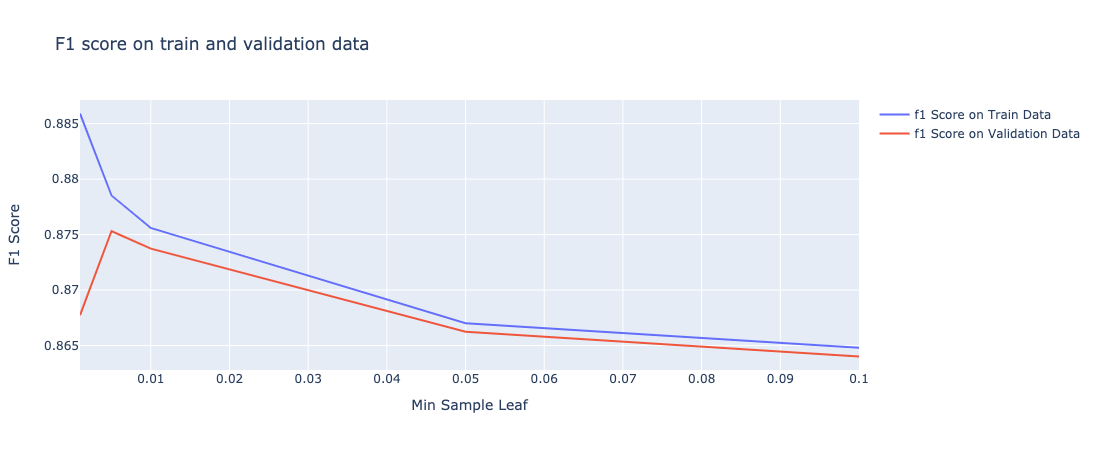

In [94]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=min_samples_leaves, y=gs.cv_results_['mean_train_F1 Score'], mode='lines', name='f1 Score on Train Data'))
fig.add_trace(go.Scatter(x=min_samples_leaves, y=gs.cv_results_['mean_test_F1 Score'], mode='lines', name='f1 Score on Validation Data'))
fig.update_layout(title='F1 score on train and validation data', xaxis_title='Min Sample Leaf', yaxis_title='F1 Score')
fig.show()

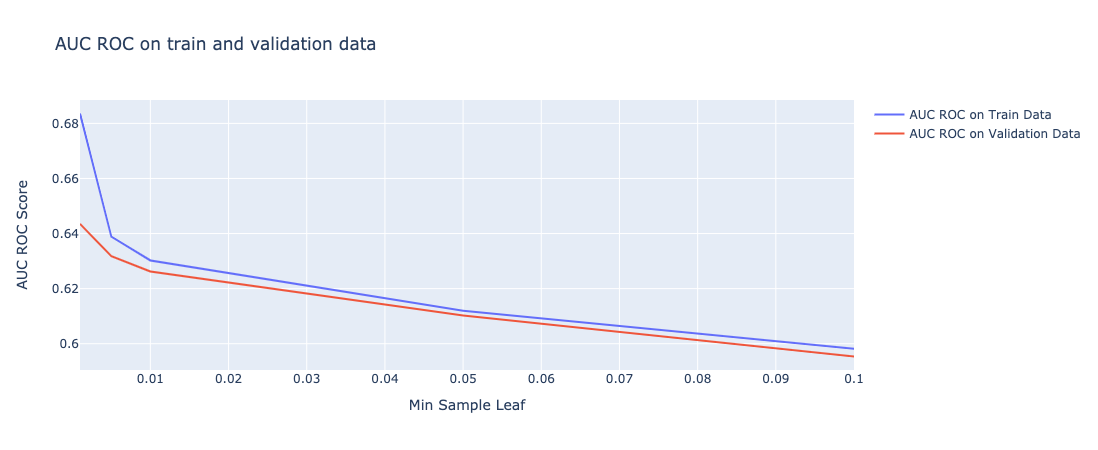

In [95]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=min_samples_leaves, y=gs.cv_results_['mean_train_AUC'], mode='lines', name='AUC ROC on Train Data'))
fig.add_trace(go.Scatter(x=min_samples_leaves, y=gs.cv_results_['mean_test_AUC'], mode='lines', name='AUC ROC on Validation Data'))
fig.update_layout(title='AUC ROC on train and validation data', xaxis_title='Min Sample Leaf', yaxis_title='AUC ROC Score')
fig.show()

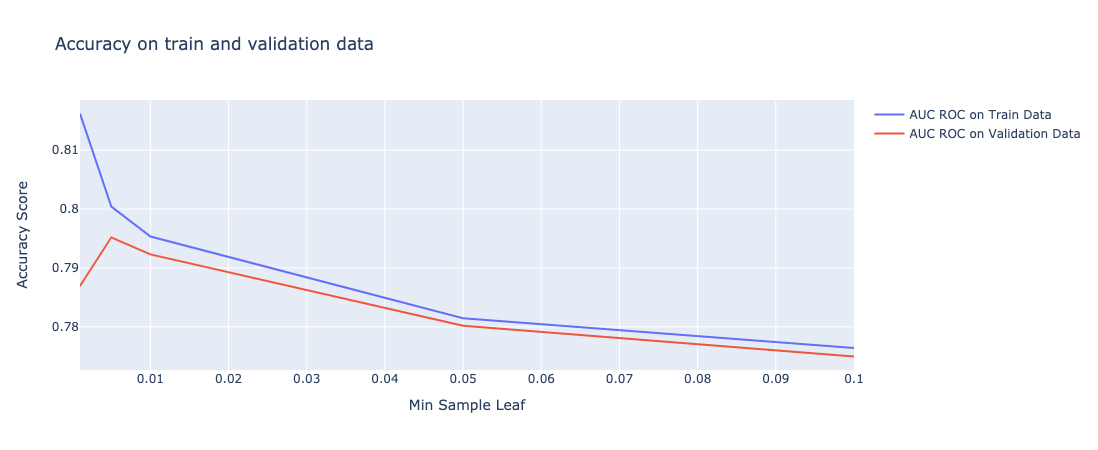

In [96]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=min_samples_leaves, y=gs.cv_results_['mean_train_Accuracy'], mode='lines', name='AUC ROC on Train Data'))
fig.add_trace(go.Scatter(x=min_samples_leaves, y=gs.cv_results_['mean_test_Accuracy'], mode='lines', name='AUC ROC on Validation Data'))
fig.update_layout(title='Accuracy on train and validation data', xaxis_title='Min Sample Leaf', yaxis_title='Accuracy Score')
fig.show()

In [116]:
print_classification_report(gs.best_estimator_, test, y_test)

********************************************************
Accuracy on Test data  0.7513485144473278
********************************************************
F1 on Test data  0.8478827012949948
********************************************************
AUC ROC on Test data  0.5773598279027239
********************************************************
Confusion matrix 
 [[ 2002  6169]
 [ 2359 23767]]
********************************************************
              precision    recall  f1-score   support

           0       0.46      0.25      0.32      8171
           1       0.79      0.91      0.85     26126

    accuracy                           0.75     34297
   macro avg       0.63      0.58      0.58     34297
weighted avg       0.71      0.75      0.72     34297

********************************************************


## KNN 

In [89]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

In [90]:
scaler = StandardScaler()
train_nn = scaler.fit_transform(train)

In [125]:
n_neighbors = [5]
params = {"n_neighbors": n_neighbors}
scoring = {'AUC': make_scorer(roc_auc_score), 'Accuracy': make_scorer(accuracy_score), "F1 Score": make_scorer(f1_score)}
clf = KNeighborsClassifier(n_jobs=-2)
gs = GridSearchCV(clf, cv=5, n_jobs=1, param_grid=params, scoring=scoring, return_train_score=True, refit="AUC")
gs.fit(train_nn, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(n_jobs=-2), n_jobs=1,
             param_grid={'n_neighbors': [5]}, refit='AUC',
             return_train_score=True,
             scoring={'AUC': make_scorer(roc_auc_score),
                      'Accuracy': make_scorer(accuracy_score),
                      'F1 Score': make_scorer(f1_score)})

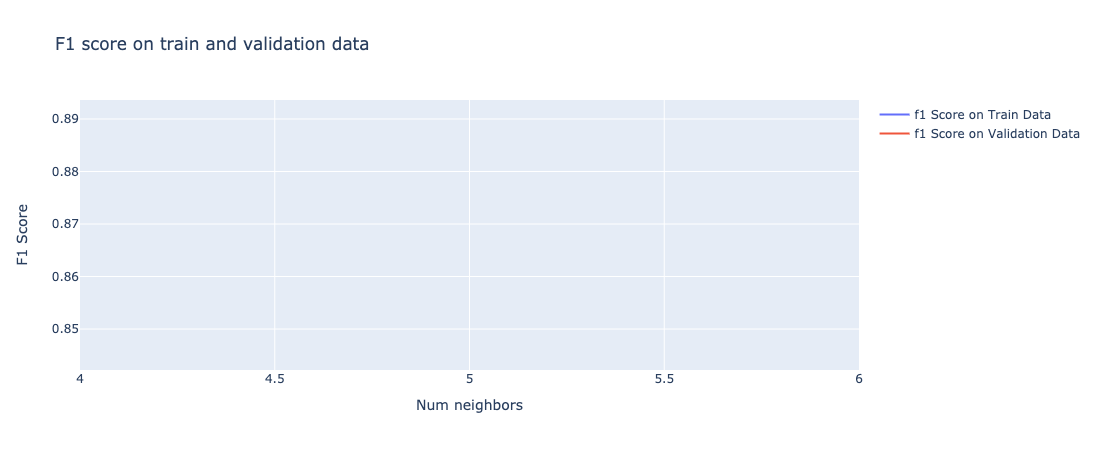

In [127]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=n_neighbors, y=gs.cv_results_['mean_train_F1 Score'], mode='lines', name='f1 Score on Train Data'))
fig.add_trace(go.Scatter(x=n_neighbors, y=gs.cv_results_['mean_test_F1 Score'], mode='lines', name='f1 Score on Validation Data'))
fig.update_layout(title='F1 score on train and validation data', xaxis_title='Num neighbors', yaxis_title='F1 Score')
fig.show()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=n_neighbors, y=gs.cv_results_['mean_train_AUC'], mode='lines', name='AUC ROC on Train Data'))
fig.add_trace(go.Scatter(x=n_neighbors, y=gs.cv_results_['mean_test_AUC'], mode='lines', name='AUC ROC on Validation Data'))
fig.update_layout(title='AUC ROC on train and validation data', xaxis_title='Num neighbors', yaxis_title='AUC ROC Score')
fig.show()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=n_neighbors, y=gs.cv_results_['mean_train_Accuracy'], mode='lines', name='AUC ROC on Train Data'))
fig.add_trace(go.Scatter(x=n_neighbors, y=gs.cv_results_['mean_test_Accuracy'], mode='lines', name='AUC ROC on Validation Data'))
fig.update_layout(title='Accuracy on train and validation data', xaxis_title='Num neighbors', yaxis_title='Accuracy Score')
fig.show()

In [ ]:
print_classification_report(gs.best_estimator_, test, y_test)

### AdaBoost

## AdaBoost performance wrt no. of estimators

In [ ]:
n_estimators = [30, 40, 50, 70, 100]
parmas = {"n_estimators": n_estimators}
base_clf = DecisisionTreeClassifier(max_depth=2, random_state=1234)
clf = AdaBoostClassifier(base_estimator=base_clf, random_state=1234)
scoring = {'AUC': make_scorer(roc_auc_score), 'Accuracy': make_scorer(accuracy_score), "F1 Score": make_scorer(f1_score)}
gs = GridSearchCV(clf, cv=5, n_jobs=1, param_grid=params, scoring=scoring, return_train_score=True, refit="AUC")
gs.fit(train, y_train)

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=n_estimators, y=gs.cv_results_['mean_train_F1 Score'], mode='lines', name='f1 Score on Train Data'))
fig.add_trace(go.Scatter(x=n_estimators, y=gs.cv_results_['mean_test_F1 Score'], mode='lines', name='f1 Score on Validation Data'))
fig.update_layout(title='F1 score on train and validation data', xaxis_title='Num Estimators', yaxis_title='F1 Score')
fig.show()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=n_estimators, y=gs.cv_results_['mean_train_AUC'], mode='lines', name='AUC ROC on Train Data'))
fig.add_trace(go.Scatter(x=n_estimators, y=gs.cv_results_['mean_test_AUC'], mode='lines', name='AUC ROC on Validation Data'))
fig.update_layout(title='AUC ROC on train and validation data', xaxis_title='Num Estimators', yaxis_title='AUC ROC Score')
fig.show()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=n_estimators, y=gs.cv_results_['mean_train_Accuracy'], mode='lines', name='AUC ROC on Train Data'))
fig.add_trace(go.Scatter(x=n_estimators, y=gs.cv_results_['mean_test_Accuracy'], mode='lines', name='AUC ROC on Validation Data'))
fig.update_layout(title='Accuracy on train and validation data', xaxis_title='Num Estimators', yaxis_title='Accuracy Score')
fig.show()

In [ ]:
print_classification_report(gs.best_estimator_, test, y_test)

### AdaBoost performance wrt learning_rate

In [ ]:
lr = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]
parmas = {"learning_rate": lr}
base_clf = DecisisionTreeClassifier(max_depth=2, random_state=1234)
clf = AdaBoostClassifier(base_estimator=base_clf, random_state=1234)
scoring = {'AUC': make_scorer(roc_auc_score), 'Accuracy': make_scorer(accuracy_score), "F1 Score": make_scorer(f1_score)}
gs = GridSearchCV(clf, cv=5, n_jobs=1, param_grid=params, scoring=scoring, return_train_score=True, refit="AUC")
gs.fit(train, y_train)

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=lr, y=gs.cv_results_['mean_train_F1 Score'], mode='lines', name='f1 Score on Train Data'))
fig.add_trace(go.Scatter(x=lr, y=gs.cv_results_['mean_test_F1 Score'], mode='lines', name='f1 Score on Validation Data'))
fig.update_layout(title='F1 score on train and validation data', xaxis_title='Learning Rate', yaxis_title='F1 Score')
fig.show()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=lr, y=gs.cv_results_['mean_train_AUC'], mode='lines', name='AUC ROC on Train Data'))
fig.add_trace(go.Scatter(x=lr, y=gs.cv_results_['mean_test_AUC'], mode='lines', name='AUC ROC on Validation Data'))
fig.update_layout(title='AUC ROC on train and validation data', xaxis_title='Learning Rate', yaxis_title='AUC ROC Score')
fig.show()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=lr, y=gs.cv_results_['mean_train_Accuracy'], mode='lines', name='AUC ROC on Train Data'))
fig.add_trace(go.Scatter(x=lr, y=gs.cv_results_['mean_test_Accuracy'], mode='lines', name='AUC ROC on Validation Data'))
fig.update_layout(title='Accuracy on train and validation data', xaxis_title='Learning Rate', yaxis_title='Accuracy Score')
fig.show()

In [ ]:
print_classification_report(gs.best_estimator_, test, y_test)